# Gene-Level Clustering Analysis of Time-Resolved Fitness Data

## Overview
This notebook performs comprehensive clustering analysis on genome-wide gene disruption time-resolved fitness data. For each gene, we have five fitness LFC (Log Fold Change) values across five time points (t0-t4), along with sigmoid curve fitting parameters.

**Data Interpretation:**
- LFC ≈ 0: No fitness effect from gene disruption
- LFC > 0: Gene disruption causes growth defects
- LFC < 0: Gene disruption improves cell growth

**Analysis Goals:**
1. Cluster genes based on different feature sets (raw values, fitted values, curve parameters)
2. Compare multiple clustering algorithms
3. Determine optimal cluster numbers using statistical metrics
4. Visualize depletion curves for each cluster


In [1]:
"""
Gene-level clustering analysis setup and imports.
"""

# Standard library imports
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns


# Machine learning
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
from cycler import cycler
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ All imports successful")
logger.info("Setup complete")


2025-07-31 15:36:30,154 - INFO - Setup complete


✓ All imports successful


## ⚙️ Professional Styling Configuration

Set up consistent, publication-ready styling for all plots.

In [2]:
# Professional styling configuration
def setup_plot_style():
    """Configure matplotlib with professional, publication-ready defaults."""
    
    # General appearance
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'savefig.dpi': 300,
        'figure.dpi': 100,
        
        # Typography
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 14,
        'axes.labelweight': 'semibold',
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        
        # Line and marker properties
        'axes.linewidth': 2.0,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'patch.linewidth': 2.0,
        
        # Spine and tick properties
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.bottom': True,
        'xtick.top': False,
        'ytick.left': True,
        'ytick.right': False,
        
        # Grid properties
        'axes.grid': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'axes.axisbelow': True,
        
        # Legend properties
        'legend.frameon': True,
        'legend.numpoints': 1,
    })

def clean_axes(ax):
    """Apply clean styling to axes - removes top and right spines."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.grid(True, alpha=0.3, linewidth=0.8)
    return ax

def add_stats_annotation(ax, text, x=0.05, y=0.95):
    """Add statistical annotation to plot."""
    ax.text(x, y, text, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
           verticalalignment='top', fontsize=9)

def save_plot(fig, filename, formats=['png', 'svg'], dpi=300):
    """Save plot in multiple formats with consistent settings."""
    for fmt in formats:
        filepath = Path(f"{filename}.{fmt}")
        fig.savefig(filepath, format=fmt, dpi=dpi, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    print(f"Plot saved as: {', '.join([f'{filename}.{fmt}' for fmt in formats])}")

# Apply the styling
setup_plot_style()
print("Professional styling configuration applied!")

# Standard figure sizes for different use cases
FIGURE_SIZES = {
    'small': (4, 3),      # Single plots, supplements
    'medium': (6, 4.5),   # Standard journal figures  
    'large': (8, 6),      # Complex plots with multiple elements
    'wide': (10, 4),      # Time series, genomic data
    'square': (4, 4),     # Correlation plots, heatmaps
}

FIGURE_DPI = 300

print("Available figure sizes:", list(FIGURE_SIZES.keys()))


Professional styling configuration applied!
Available figure sizes: ['small', 'medium', 'large', 'wide', 'square']


## 🎨 Custom Color Palette

Professional color palette organized by hue families for better visual harmony and accessibility.


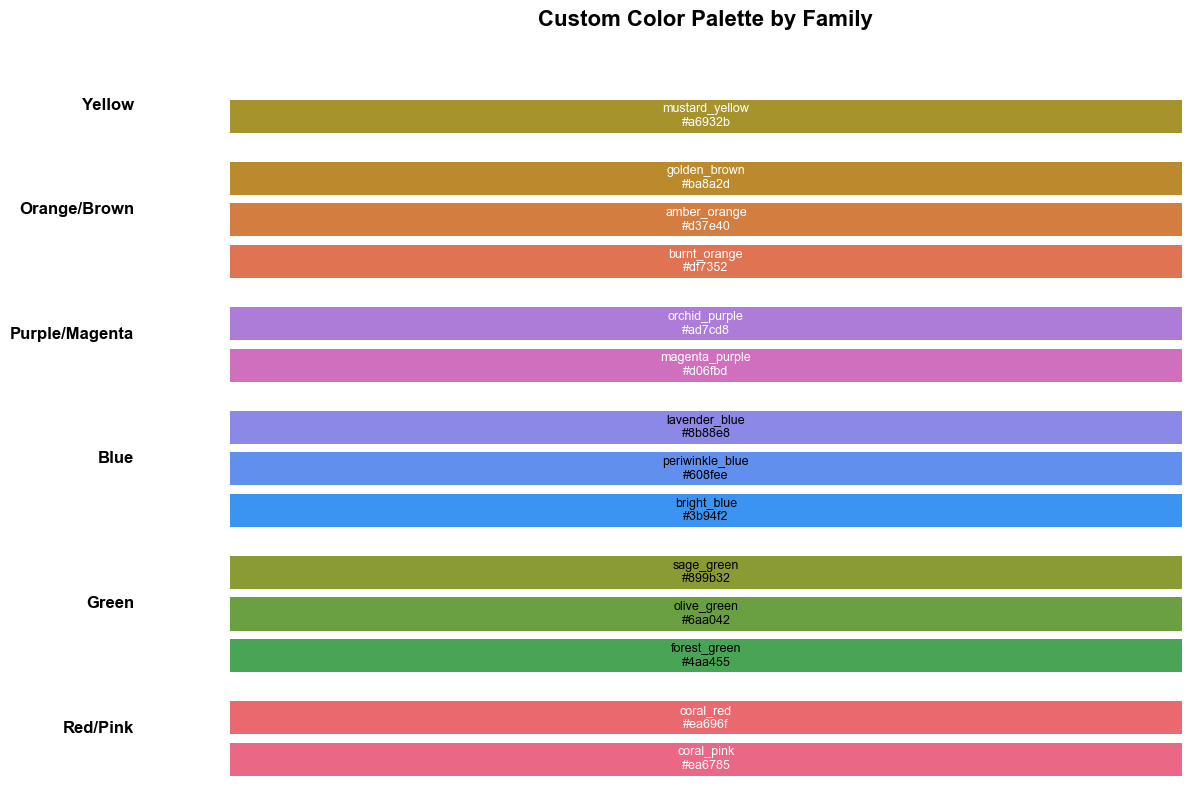

Color palette loaded successfully!
Primary trio: ['#ea696f', '#6aa042', '#608fee']
Four-category palette: ['#ea696f', '#6aa042', '#608fee', '#ad7cd8']


In [3]:
# Custom Color Palette - Organized by families
COLORS = {
    'coral_pink': '#ea6785',
    'forest_green': '#4aa455',
    'bright_blue': '#3b94f2',
    'magenta_purple': '#d06fbd',
    'golden_brown': '#ba8a2d',
    'coral_red': '#ea696f',
    'olive_green': '#6aa042',
    'periwinkle_blue': '#608fee',
    'burnt_orange': '#df7352',
    'sage_green': '#899b32',
    'lavender_blue': '#8b88e8',
    'amber_orange': '#d37e40',
    'mustard_yellow': '#a6932b',
    'orchid_purple': '#ad7cd8'
}

# Recommended color combinations
PRIMARY_TRIO = [COLORS['coral_red'], COLORS['olive_green'], COLORS['periwinkle_blue']]
FOUR_CATEGORY = PRIMARY_TRIO + [COLORS['orchid_purple']]
SIX_CATEGORY = FOUR_CATEGORY + [COLORS['magenta_purple'], COLORS['golden_brown']]

# Set as default matplotlib color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=PRIMARY_TRIO)

# Display color palette
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
families = {
    'Red/Pink': ['coral_pink', 'coral_red'],
    'Green': ['forest_green', 'olive_green', 'sage_green'],
    'Blue': ['bright_blue', 'periwinkle_blue', 'lavender_blue'],
    'Purple/Magenta': ['magenta_purple', 'orchid_purple'],
    'Orange/Brown': ['burnt_orange', 'amber_orange', 'golden_brown'],
    'Yellow': ['mustard_yellow']
}

y_pos = 0
for family_name, color_names in families.items():
    for i, color_name in enumerate(color_names):
        ax.barh(y_pos, 1, color=COLORS[color_name], height=0.8)
        ax.text(0.5, y_pos, f'{color_name}\n{COLORS[color_name]}', 
               ha='center', va='center', fontsize=9, 
               color='white' if color_name in ['coral_pink', 'coral_red', 'magenta_purple', 'orchid_purple', 'burnt_orange', 'amber_orange', 'golden_brown', 'mustard_yellow'] else 'black')
        y_pos += 1
    y_pos += 0.5  # Add space between families
    
    # Add family label
    ax.text(-0.1, y_pos - len(color_names)/2 - 0.75, family_name, 
           ha='right', va='center', fontsize=12, weight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, y_pos)
ax.set_title('Custom Color Palette by Family', fontsize=16, weight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Color palette loaded successfully!")
print(f"Primary trio: {PRIMARY_TRIO}")
print(f"Four-category palette: {FOUR_CATEGORY}")

def create_gradient_colormap(base_color, name='custom_gradient'):
    """
    Create a gradient colormap from white to a given base color.
    
    Args:
        base_color: Base color (can be hex string, RGB tuple, or named color)
        name: Name for the colormap
        
    Returns:
        matplotlib.colors.LinearSegmentedColormap
    """
    # Convert base color to RGB if needed
    if isinstance(base_color, str):
        base_rgb = mcolors.to_rgb(base_color)
    else:
        base_rgb = base_color
    
    # Create gradient from 0.4 transparent base color to base color
    light_base = tuple(0.9 + 0.1*c for c in base_rgb)  # 10% base color, 90% white
    colors = [light_base, base_rgb]
    n_bins = 10
    cmap = mcolors.LinearSegmentedColormap.from_list(name, colors, N=n_bins)
    return cmap


## 1. Data Loading and Exploration

In [4]:
def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """
    Load the gene-level statistics data and perform initial exploration.
    
    Args:
        file_path: Path to the CSV file containing gene statistics
        
    Returns:
        DataFrame with loaded data
    """
    logger.info(f"Loading data from {file_path}")
    
    # Load data
    data_path = Path(file_path)
    if not data_path.exists():
        raise FileNotFoundError(f"Data file not found: {file_path}")
    
    df = pd.read_csv(data_path, sep="\t")
    
    # Basic data exploration
    logger.info(f"Data shape: {df.shape}")
    logger.info(f"Columns: {list(df.columns)}")
    
    # Check for missing values
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        logger.warning(f"Missing values found:\n{missing_summary[missing_summary > 0]}")
    
    # Basic statistics
    print("\n=== DATA SUMMARY ===")
    print(f"Total genes: {len(df)}")
    print(f"Successful fits: {(df['Status'] == 'Success').sum()}")
    print(f"Failed fits: {(df['Status'] != 'Success').sum()}")
    
    # Essentiality distribution
    if 'DeletionLibrary_essentiality' in df.columns:
        essentiality_counts = df['DeletionLibrary_essentiality'].value_counts()
        print(f"\nEssentiality distribution:")
        for category, count in essentiality_counts.items():
            print(f"  {category}: {count} ({count/len(df)*100:.1f}%)")
    
    return df

# Load the data
data_file = "../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv"
df = load_and_explore_data(data_file)

verified_essentiality = pd.read_excel("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/resources/verfication_results_summary.xlsx", index_col=0).dropna(subset=["Verified essentiality"])["Verified essentiality"].to_dict()
df.insert(3, "RevisedDeletion_essentiality", df["DeletionLibrary_essentiality"].map(lambda x: verified_essentiality[x] if x in verified_essentiality else x))

output_folder = Path("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/20_gene_level_clustering")
output_folder.mkdir(parents=True, exist_ok=True)


2025-07-31 15:36:37,732 - INFO - Loading data from ../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv
2025-07-31 15:36:37,752 - INFO - Data shape: (4519, 27)
2025-07-31 15:36:37,752 - INFO - Columns: ['Systematic ID', 'Name', 'FYPOviability', 'DeletionLibrary_essentiality', 'time_points', 'Status', 'A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE', 't0', 't1', 't2', 't3', 't4', 't0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted', 't0_residual', 't1_residual', 't2_residual', 't3_residual', 't4_residual']



=== DATA SUMMARY ===
Total genes: 4519
Successful fits: 4519
Failed fits: 0

Essentiality distribution:
  V: 3173 (70.2%)
  E: 1144 (25.3%)
  Not_determined: 202 (4.5%)


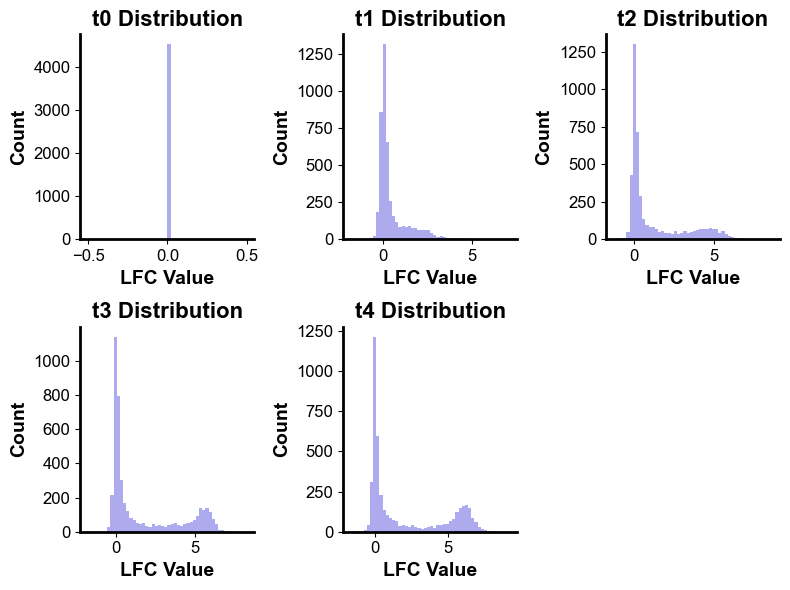

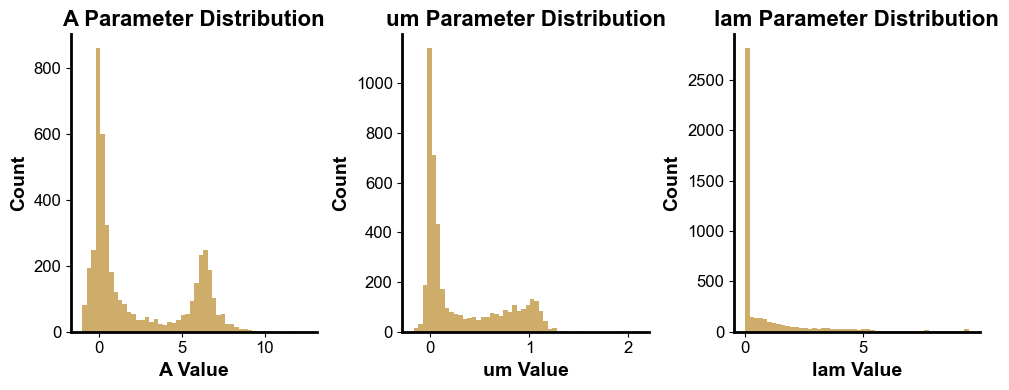

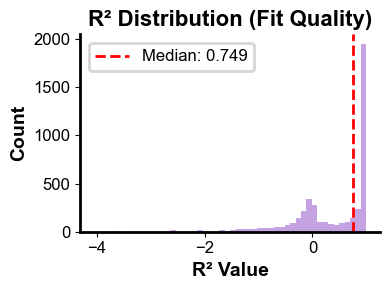

In [5]:
def visualize_data_distributions(df: pd.DataFrame) -> None:
    """
    Create visualizations to understand data distributions.
    
    Args:
        df: Input DataFrame with gene statistics
    """
    fig, axes = plt.subplots(2, 3, figsize=FIGURE_SIZES['large'])
    
    # Raw fitness values distribution
    raw_cols = ['t0', 't1', 't2', 't3', 't4']
    for i, col in enumerate(raw_cols):
        if i < 5:
            ax = axes[0, i] if i < 3 else axes[1, i-3]
            ax.hist(df[col], bins=50, alpha=0.7, color=COLORS['lavender_blue'])
            ax.set_title(f'{col} Distribution')
            ax.set_xlabel('LFC Value')
            ax.set_ylabel('Count')
    
    # Remove empty subplot
    if len(raw_cols) < 6:
        fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Curve fitting parameters
    fig, axes = plt.subplots(1, 3, figsize=FIGURE_SIZES['wide'])
    
    param_cols = ['A', 'um', 'lam']
    for i, col in enumerate(param_cols):
        axes[i].hist(df[col], bins=50, alpha=0.7, color=COLORS['golden_brown'])
        axes[i].set_title(f'{col} Parameter Distribution')
        axes[i].set_xlabel(f'{col} Value')
        axes[i].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # R² distribution
    plt.figure(figsize=FIGURE_SIZES['small'])
    plt.hist(df['R2'], bins=50, alpha=0.7, color=COLORS['orchid_purple'])
    plt.title('R² Distribution (Fit Quality)')
    plt.xlabel('R² Value')
    plt.ylabel('Count')
    plt.axvline(df['R2'].median(), color='red', linestyle='--', 
                label=f'Median: {df["R2"].median():.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize data distributions
visualize_data_distributions(df)


## 2. Data Preparation for Clustering

In [6]:
# std_scaler = StandardScaler()
# robust_scaler = RobustScaler(quantile_range=(0.25, 0.75), unit_variance=True)

data = df[["um", "lam"]].copy()
data["um"] = data["um"].apply(lambda x: x if x < 1.3 else 1.3)
data["lam"] = data["lam"].apply(lambda x: x/10)
data = data.values
scaled_data = data

# scaled_data = std_scaler.fit_transform(data)
# scaled_data = robust_scaler.fit_transform(data)

scaled_data.shape

(4519, 2)

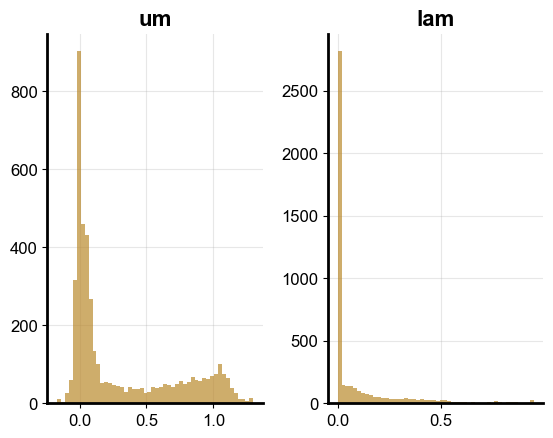

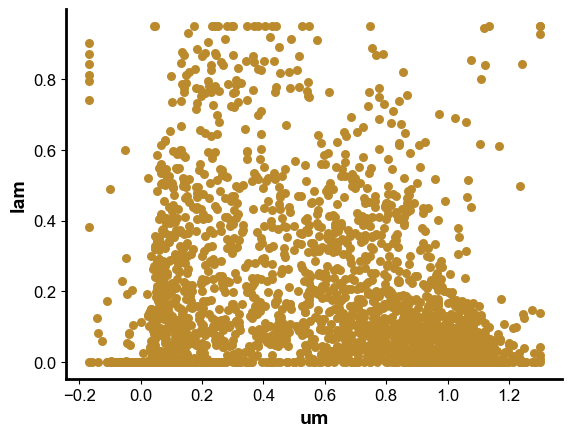

In [7]:
pd.DataFrame(scaled_data, columns=["um", "lam"]).hist(bins=50, alpha=0.7, color=COLORS['golden_brown'])
plt.show()
plt.close()
pd.DataFrame(scaled_data, columns=["um", "lam"]).plot.scatter(x="um", y="lam", c=COLORS['golden_brown'])
plt.show()
plt.close()


## 3. Optimal Cluster Number Determination

2025-07-26 01:40:35,364 - INFO - Evaluating cluster numbers for um_lam


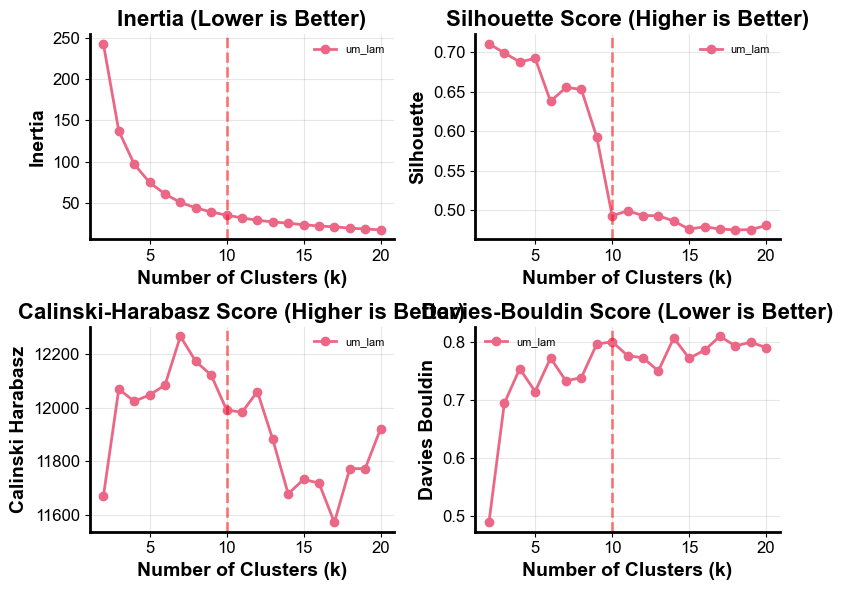

In [104]:
def evaluate_cluster_numbers(data: np.ndarray, dataset_name: str, 
                            k_range: range = range(2, 21)) -> Dict[str, List[float]]:
    """
    Evaluate different numbers of clusters using multiple metrics.
    
    Args:
        data: Standardized feature matrix
        dataset_name: Name of the dataset for logging
        k_range: Range of cluster numbers to test
        
    Returns:
        Dictionary containing metrics for each k
    """
    logger.info(f"Evaluating cluster numbers for {dataset_name}")
    
    metrics = {
        'k_values': list(k_range),
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in k_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        
        # Calculate metrics
        metrics['inertia'].append(kmeans.inertia_)
        
        if k > 1:  # These metrics require at least 2 clusters
            metrics['silhouette'].append(silhouette_score(data, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(data, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(data, labels))
        else:
            metrics['silhouette'].append(np.nan)
            metrics['calinski_harabasz'].append(np.nan)
            metrics['davies_bouldin'].append(np.nan)
    
    return metrics

def plot_cluster_metrics(all_metrics: Dict[str, Dict[str, List[float]]]) -> None:
    """
    Plot clustering evaluation metrics for all datasets.
    
    Args:
        all_metrics: Dictionary containing metrics for each dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZES['large'])
    
    metric_names = ['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin']
    metric_titles = ['Inertia (Lower is Better)', 'Silhouette Score (Higher is Better)',
                    'Calinski-Harabasz Score (Higher is Better)', 'Davies-Bouldin Score (Lower is Better)']
    
    colors_list = list(COLORS.values())
    
    for i, (metric, title) in enumerate(zip(metric_names, metric_titles)):
        ax = axes[i//2, i%2]
        
        for j, (dataset_name, metrics) in enumerate(all_metrics.items()):
            color = colors_list[j % len(colors_list)]
            ax.plot(metrics['k_values'], metrics[metric], 
                   marker='o', linewidth=2, label=dataset_name, color=color)
        
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(title)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Highlight k=10 (expected cluster number)
        ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Expected k=10')
    
    plt.tight_layout()
    plt.show()

# Evaluate cluster numbers for all datasets
all_metrics = {}
all_metrics["um_lam"] = evaluate_cluster_numbers(data, "um_lam")

# Plot metrics
plot_cluster_metrics(all_metrics)


## 4. Clustering Analysis with Multiple Methods

In [8]:
def perform_clustering_analysis(data: np.ndarray, n_clusters: int = 10) -> Dict[str, np.ndarray]:
    """
    Apply multiple clustering algorithms to the data.
    
    Args:
        data: Standardized feature matrix
        n_clusters: Number of clusters to create
        
    Returns:
        Dictionary containing cluster labels from different methods
    """
    logger.info(f"Performing clustering with {n_clusters} clusters")
    
    clustering_results = {}
    
    # 1. K-means
    logger.info("Running K-means clustering")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clustering_results['kmeans'] = kmeans.fit_predict(data)
    
    # 2. Hierarchical clustering (bottom-up/agglomerative)
    logger.info("Running agglomerative hierarchical clustering")
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean')
    clustering_results['hierarchical_agg'] = agg_cluster.fit_predict(data)
    
    # 3. Hierarchical clustering (top-down) using scipy
    logger.info("Running divisive hierarchical clustering")
    # Note: scikit-learn doesn't have divisive clustering, so we'll use linkage
    linkage_matrix = linkage(data, method='complete', metric='cityblock')
    clustering_results['hierarchical_div'] = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1

    # 4. Gaussian Mixture Model
    logger.info("Running Gaussian Mixture Model")
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clustering_results['gmm'] = gmm.fit_predict(data)
    
    # Print cluster size distributions
    print("\n=== CLUSTER SIZE DISTRIBUTIONS ===")
    for method, labels in clustering_results.items():
        unique, counts = np.unique(labels, return_counts=True)
        print(f"{method}:")
        for cluster_id, count in zip(unique, counts):
            print(f"  Cluster {cluster_id}: {count} genes")
    
    return clustering_results

def calculate_clustering_metrics(data: np.ndarray, clustering_results: Dict[str, np.ndarray]) -> pd.DataFrame:
    """
    Calculate clustering quality metrics for all methods.
    
    Args:
        data: Standardized feature matrix
        clustering_results: Dictionary of clustering results
        
    Returns:
        DataFrame with clustering metrics
    """
    logger.info("Calculating clustering quality metrics")
    
    metrics_df = []
    
    for method, labels in clustering_results.items():
        metrics = {
            'method': method,
            'silhouette_score': silhouette_score(data, labels),
            'calinski_harabasz_score': calinski_harabasz_score(data, labels),
            'davies_bouldin_score': davies_bouldin_score(data, labels),
            'n_clusters': len(np.unique(labels))
        }
        metrics_df.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_df)
    metrics_df = metrics_df.round(3)
    
    print("\n=== CLUSTERING QUALITY METRICS ===")
    print(metrics_df.to_string(index=False))
    
    return metrics_df

# Perform clustering analysis for each dataset
all_clustering_results = {}
all_metrics = {}
cluster_num = 64

dataset_name = "um_lam"
print(f"\n{'='*50}")
print(f"CLUSTERING ANALYSIS: {dataset_name.upper()}")
print(f"{'='*50}")

# Perform clustering
clustering_results = perform_clustering_analysis(data, n_clusters=cluster_num)
all_clustering_results[dataset_name] = clustering_results

# Calculate metrics
metrics_df = calculate_clustering_metrics(data, clustering_results)
all_metrics[dataset_name] = metrics_df


2025-07-31 15:36:44,998 - INFO - Performing clustering with 64 clusters
2025-07-31 15:36:44,998 - INFO - Running K-means clustering



CLUSTERING ANALYSIS: UM_LAM


2025-07-31 15:36:45,496 - INFO - Running agglomerative hierarchical clustering
2025-07-31 15:36:45,936 - INFO - Running divisive hierarchical clustering
2025-07-31 15:36:46,356 - INFO - Running Gaussian Mixture Model
2025-07-31 15:36:47,214 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 848 genes
  Cluster 1: 36 genes
  Cluster 2: 24 genes
  Cluster 3: 20 genes
  Cluster 4: 36 genes
  Cluster 5: 20 genes
  Cluster 6: 116 genes
  Cluster 7: 36 genes
  Cluster 8: 349 genes
  Cluster 9: 6 genes
  Cluster 10: 39 genes
  Cluster 11: 77 genes
  Cluster 12: 44 genes
  Cluster 13: 15 genes
  Cluster 14: 37 genes
  Cluster 15: 41 genes
  Cluster 16: 22 genes
  Cluster 17: 17 genes
  Cluster 18: 15 genes
  Cluster 19: 12 genes
  Cluster 20: 30 genes
  Cluster 21: 43 genes
  Cluster 22: 85 genes
  Cluster 23: 72 genes
  Cluster 24: 46 genes
  Cluster 25: 6 genes
  Cluster 26: 54 genes
  Cluster 27: 32 genes
  Cluster 28: 33 genes
  Cluster 29: 573 genes
  Cluster 30: 62 genes
  Cluster 31: 52 genes
  Cluster 32: 27 genes
  Cluster 33: 69 genes
  Cluster 34: 57 genes
  Cluster 35: 22 genes
  Cluster 36: 31 genes
  Cluster 37: 34 genes
  Cluster 38: 13 genes
  Cluster 39: 52 genes
  Cluster 40: 42 genes
  Cluster 41: 10 gene

In [9]:
for dataset_name, clustering_results in all_clustering_results.items():
    for method, labels in clustering_results.items():
        cluster = f"cluster_{method}_{dataset_name}"
        df[cluster] = labels

previous_manual_clustering = pd.read_excel("../../resources/20250317_plateau_GWMs.xlsx", index_col=0)["cluster_order"].to_dict()
df["previous_manual_clustering"] = df["Systematic ID"].map(previous_manual_clustering)
df["previous_manual_clustering"] = df["previous_manual_clustering"].fillna(15)

# df.to_csv(output_folder/f"gene_level_clustering_results_{cluster_num}.tsv", sep="\t", index=False)

## 5. Manually Merge Clusters and Visualization of Clustering Results

### 5.1 Manually merge clusters

In [10]:

colors_multi = ["#452062",
"#8be93d",
"#6d2bde",
"#5bdb62",
"#cc3ce7",
"#cfe044",
"#5447d1",
"#e5c83b",
"#9643bf",
"#6cac2e",
"#d93eb4",
"#63e3a1",
"#49288c",
"#b8e181",
"#6474df",
"#da9b33",
"#c875d8",
"#55a95c",
"#dd3d86",
"#69decb",
"#e63923",
"#63c0df",
"#db632f",
"#6897da",
"#c1712e",
"#425594",
"#9ca13e",
"#913379",
"#477126",
"#de4867",
"#3c8b67",
"#cc403c",
"#afddd8",
"#271c45",
"#e4cc7f",
"#9379c4",
"#90782c",
"#d9a5df",
"#2b4826",
"#dc76ab",
"#d0e2aa",
"#321521",
"#e1d2bf",
"#182f3b",
"#d49968",
"#537d9a",
"#8a3e1f",
"#b6bbdc",
"#652524",
"#97bc8f",
"#9e2e4c",
"#649f9e",
"#612643",
"#788a63",
"#b15f6a",
"#385f5d",
"#e28c7e",
"#3f311f",
"#d4a4b1",
"#605320",
"#8f6c8b",
"#b09a7e",
"#52485f",
"#8a6653"]

colors8 = ["#d05d41",
"#c2983d",
"#d34b80",
"#af53cc",
"#4db79a",
"#73af48",
"#637ad2",
"#c37dc2"]

def plot_cluster(ax, df, cluster_col, cluster, colors_multi, fade_alpha=True, cluster_minus_one=False, legend=False):
    if cluster_minus_one:
        cluster_idx = cluster - 1
    else:
        cluster_idx = cluster
    x = df.query(f"{cluster_col} == @cluster")["um"]
    y = df.query(f"{cluster_col} == @cluster")["lam"]
    if fade_alpha:
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        cmap = create_gradient_colormap(colors_multi[cluster_idx], f'{cluster}_gradient')
        ax.scatter(x, y, c=z, s=4, cmap=cmap, label=f"Cluster {cluster} (n={len(x)})")
    else:
        ax.scatter(x, y, c=colors_multi[cluster_idx], s=4, label=f"Cluster {cluster} (n={len(x)})")
    centroid_x = x.mean()
    centroid_y = y.mean()
    ax.text(centroid_x, centroid_y, f"{cluster}", fontsize=14, fontweight="bold", 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="none", alpha=0.8))
    ax.set_xlabel("um")
    ax.set_ylabel("lam")
    ax.set_xticks(np.arange(0, 2, 0.1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.grid(True, linestyle="--", alpha=0.5, color="gray")
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=True, markerscale=3)

    return ax

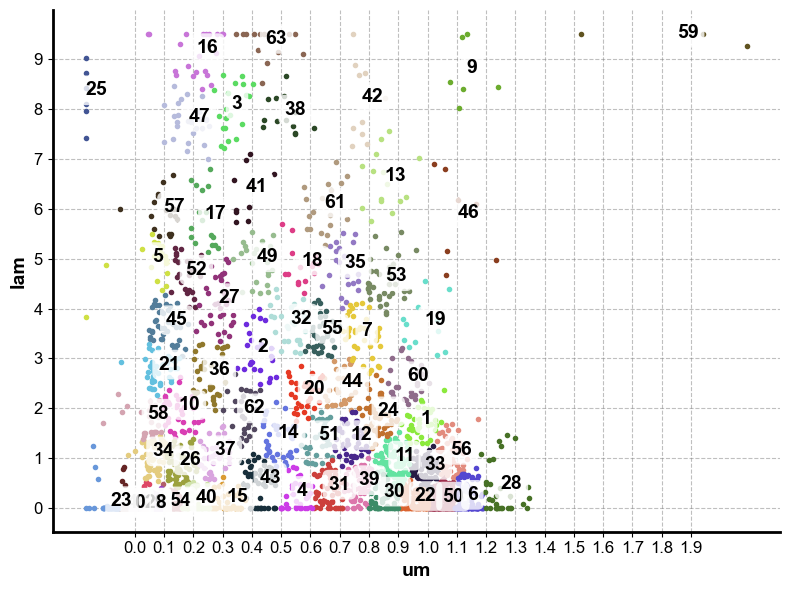

In [11]:
fig, ax = plt.subplots(1,1,figsize=FIGURE_SIZES["large"])

for cluster in df["cluster_kmeans_um_lam"].unique().tolist():
    plot_cluster(ax, df, "cluster_kmeans_um_lam", cluster, colors_multi, fade_alpha=False)
    
plt.tight_layout()
plt.show()
plt.close()

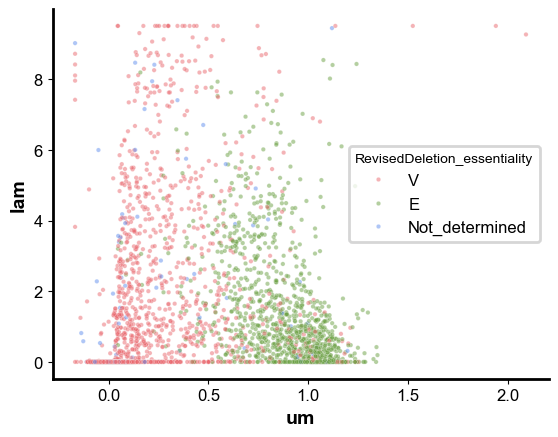

In [12]:
sns.scatterplot(data=df, x="um", y="lam", hue="RevisedDeletion_essentiality", alpha=0.5, s=10)
plt.show()
plt.close()

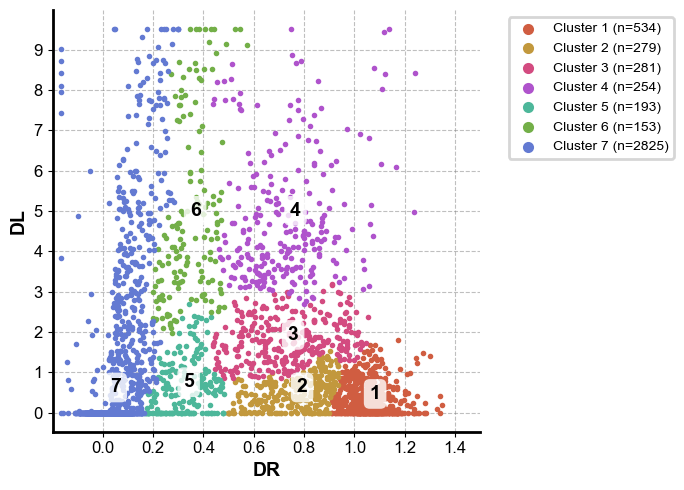

In [26]:
reformat_cluster = {
    0: 0,
    1: 12,
    2: 2,
    3: 2,
    4: 4,
    5: 0,
    6: 6,
    7: 7,
    8: 0,
    9: 7,
    10: 0,
    11: 4,
    12: 12,
    13: 7,
    14: 12,
    15: 15,
    16: 0,
    17: 0,
    18: 7,
    19: 7,
    20: 12,
    21: 0,
    22: 6,
    23: 0,
    24: 12,
    25: 0,
    26: 0,
    27: 2,
    28: 6,
    29: 0,
    30: 4,
    31: 4,
    32: 7,
    33: 6,
    34: 0,
    35: 7,
    36: 2,
    37: 15,
    38: 7,
    39: 4,
    40: 15,
    41: 2,
    42: 7,
    43: 15,
    44: 12,
    45: 0,
    46: 7,
    47: 0,
    48: 0,
    49: 2,
    50: 6,
    51: 12,
    52: 0,
    53: 7,
    54: 0,
    55: 7,
    56: 6,
    57: 0,
    58: 0,
    59: 7,
    60: 12,
    61: 7,
    62: 15,
    63: 2
}

cluster_name = "cluster_kmeans_um_lam"

df["revised_cluster"] = df[cluster_name].map(reformat_cluster)

reorder_reformat_cluster = {
    6: 1,
    4: 2,
    12: 3,
    7: 4,
    15: 5,
    2: 6,
    0: 7
}

df["revised_cluster"] = df["revised_cluster"].map(reorder_reformat_cluster)

df.to_csv(output_folder/f"gene_level_clustering_results_kmeans64mergedto8.tsv", sep="\t", index=False)

df = pd.read_csv(output_folder/f"gene_level_clustering_results_kmeans64mergedto8.tsv", sep="\t")

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for cluster in sorted(df["revised_cluster"].unique().tolist()):
    plot_cluster(ax, df, "revised_cluster", cluster, colors8, fade_alpha=False, cluster_minus_one=True, legend=True)
ax.set_xlabel("DR")
ax.set_ylabel("DL")
ax.set_title("", fontsize=16, fontweight="bold")
ax.set_xticks(np.arange(0, 2, 0.2))
ax.set_xlim(-0.2, 1.5)
plt.tight_layout()
plt.show()
plt.close()

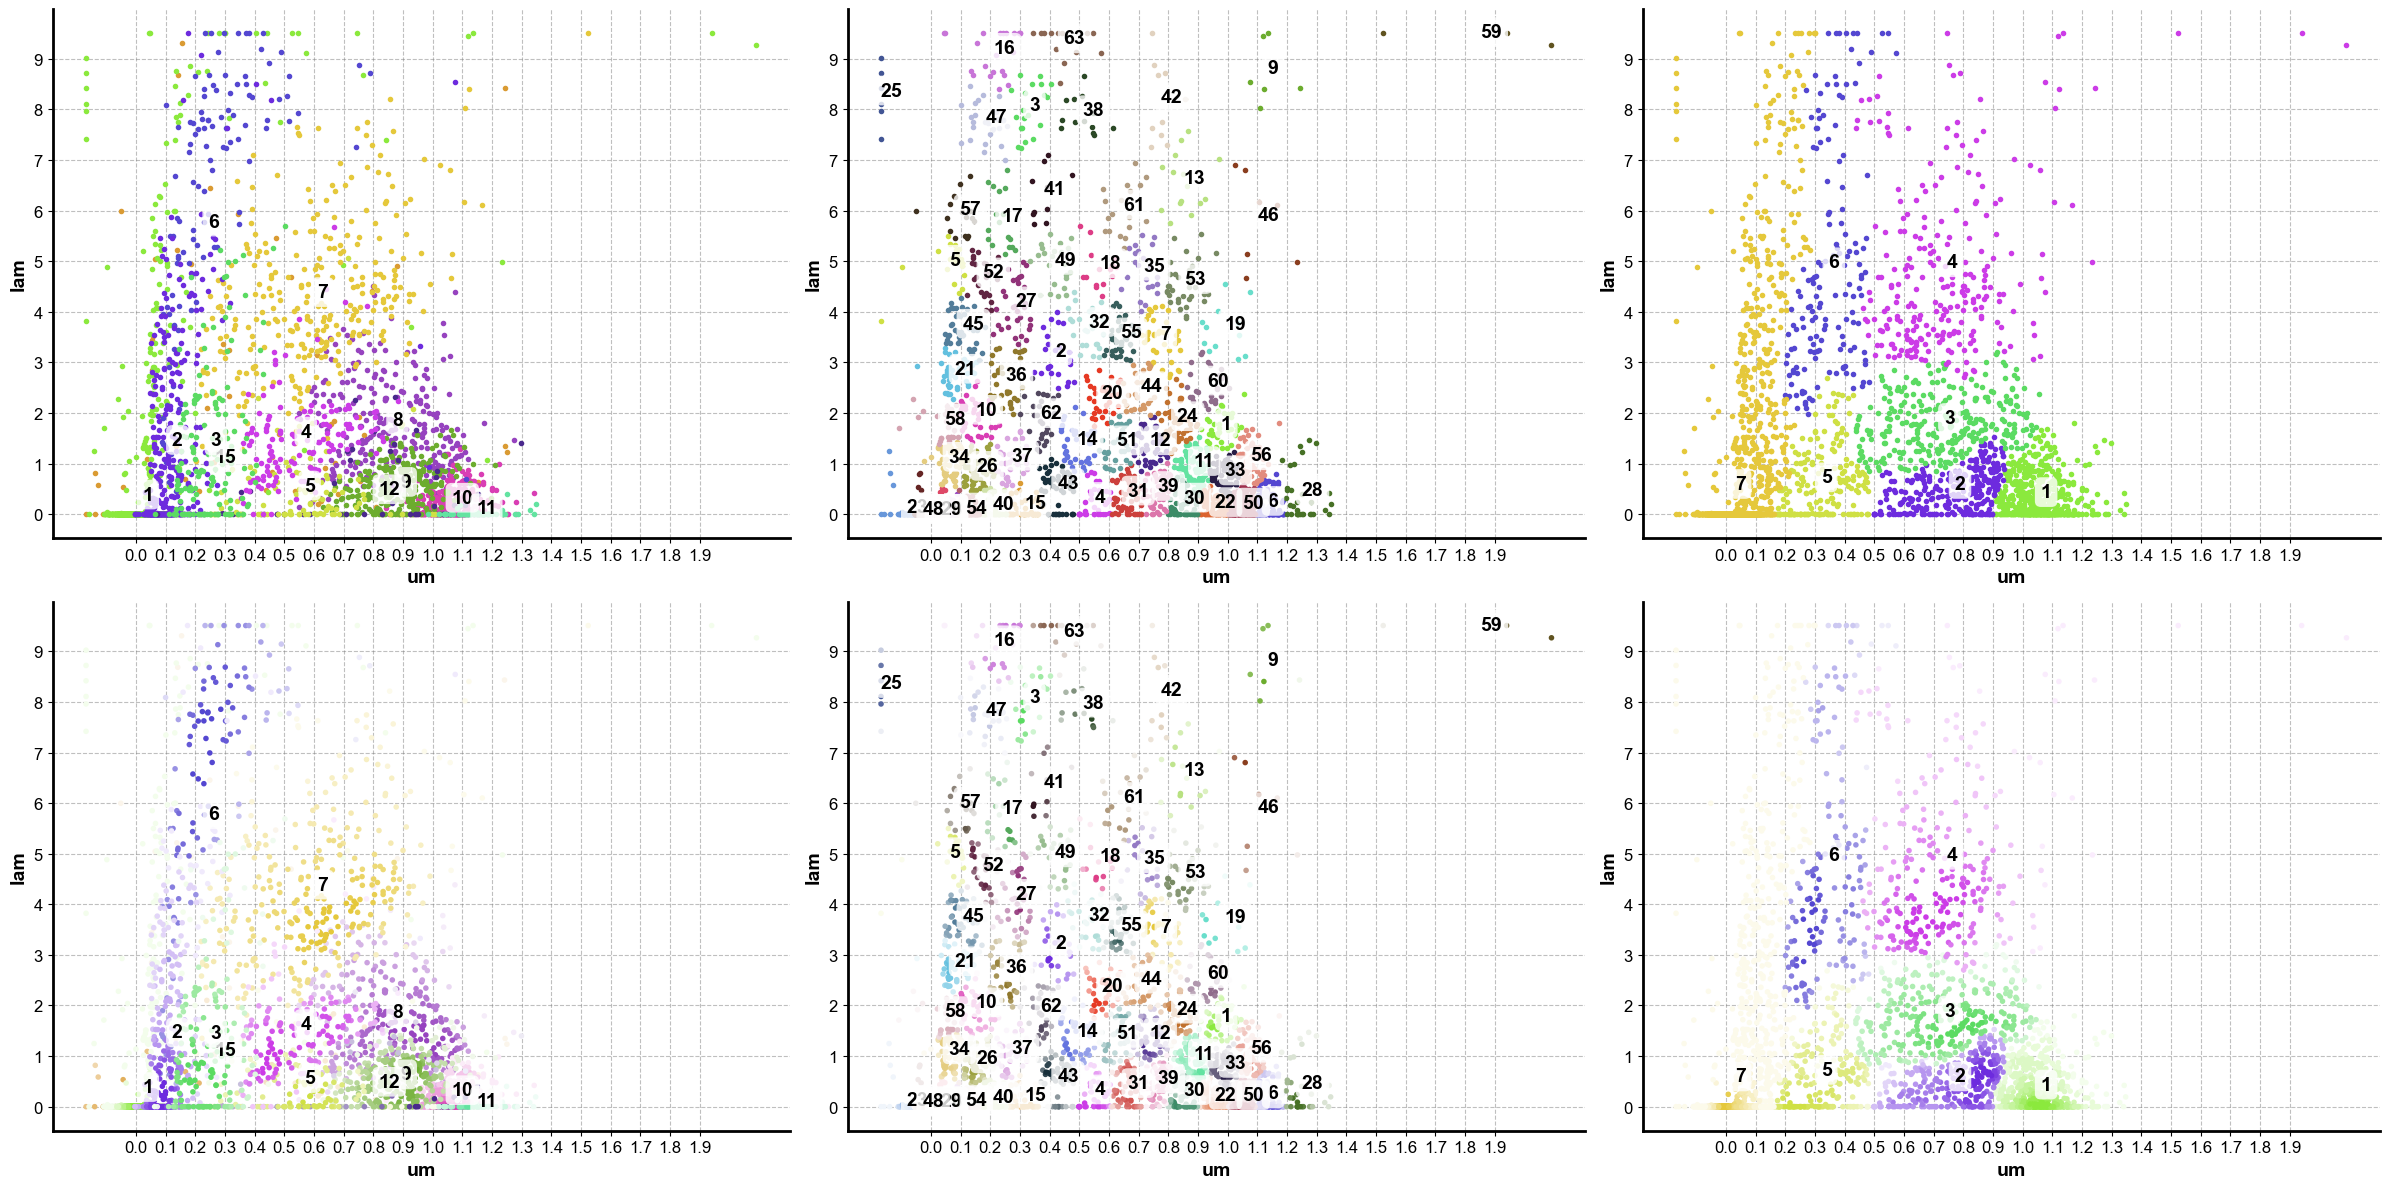

In [27]:
fig, axes = plt.subplots(2,3,figsize=(24,12))

cluster_types = {
    "previous_manual_clustering": df["previous_manual_clustering"].unique().tolist(),
    cluster_name: list(reformat_cluster.keys()),
    "revised_cluster": list(reorder_reformat_cluster.values())
}

for col, (cluster_type, cluster_values) in enumerate(cluster_types.items()):
    for cluster in cluster_values:
        cluster = int(cluster)
        plot_cluster(axes[0, col], df, cluster_type, cluster, colors_multi, fade_alpha=False)
        plot_cluster(axes[1, col], df, cluster_type, cluster, colors_multi, fade_alpha=True)
    
plt.tight_layout()
plt.show()
plt.close()

### 5.2 Show each cluster in um_lam

In [28]:
def show_cluster_on_um_lam(df, cluster_col, col_num):
    """
    Show clusters on um and lam parameters.
    
    Args:
        df: DataFrame containing um and lam parameters
        cluster_col: Column name of the cluster
        col_num: Number of columns to show
    """
    df_success = df[df['Status'] == 'Success'].copy()
    cluster_metrics = df.groupby(cluster_col).agg({"um": "median", "lam": "median", "A": "median"}).round({"um": 1, "lam": 0, "A": 0})
    cluster_metrics = cluster_metrics.sort_values(by=["lam", "um", "A"])
    labels = cluster_metrics.index.tolist()

    n_clusters = len(labels)
    n_cols = col_num
    n_rows = (n_clusters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), sharex=True, sharey=True)
    axes = axes.flatten()

    x_all = df_success["um"]
    y_all = df_success["lam"]

    for idx, label in enumerate(labels):
        label = int(label)
        ax = axes[idx]
        ax.scatter(x_all, y_all, c='lightgray', s=10, alpha=0.4)
        x = df_success.query(f"{cluster_col} == @label")["um"]
        y = df_success.query(f"{cluster_col} == @label")["lam"]
        try:
            xy = np.vstack([x,y])
            z = stats.gaussian_kde(xy)(xy)
            ax.scatter(x, y, c=z, s=10, cmap='viridis')
        except:
            ax.scatter(x, y, c='red', s=10)

        ax.set_title(f"Cluster {label} (n={len(x)})", fontsize=14)
        ax.set_xlabel("um")
        ax.set_ylabel("lam")
        ax.grid(True)
    plt.tight_layout()

    return fig

with matplotlib.backends.backend_pdf.PdfPages(output_folder/"cluster_on_um_lam.pdf") as pdf:

    fig = show_cluster_on_um_lam(df, "previous_manual_clustering", 4)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig = show_cluster_on_um_lam(df, "revised_cluster", 4)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig = show_cluster_on_um_lam(df, "cluster_kmeans_um_lam", 4)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

### 5.3 Plot depletion curves

In [29]:
def plot_depletion_curves(df: pd.DataFrame, cluster_name: str, labels: list | None, col_num: int = 3,
                          use_fitted: bool = False) -> plt.Figure:
    """
    Plot depletion curves for each cluster.
    
    Args:
        df: Original DataFrame with gene data (successful fits only)
        labels: Cluster labels
        use_fitted: Whether to use fitted values instead of raw values
        
    Returns:
        Figure object
    """
    # Time points
    time_points = [0.0, 2.352, 5.588, 9.104, 12.48]
    
    # Choose columns based on fitted or raw
    if use_fitted:
        value_cols = ['t0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']
        title_suffix = "(Fitted Values)"
    else:
        value_cols = ['t0', 't1', 't2', 't3', 't4']
        title_suffix = "(Raw Values)"

    if labels is None:
        cluster_metrics = df.groupby(cluster_name).agg({"um": "median", "lam": "median", "A": "median"}).round({"um":2, "lam": 0, "A": 0}).sort_values(by=["A", "um", "lam"])
        labels = cluster_metrics.index.tolist()
        cluster_num = len(labels)
        row_num = (cluster_num + col_num - 1) // col_num
        labels = np.array_split(labels, row_num)
    else:
        row_num = len(labels)
        col_num = max([len(label) for label in labels])
        # cluster_family_metrics = pd.DataFrame(columns=["cluster_family", "cluster_family_um", "cluster_family_lam", "cluster_family_A"])
        # for idx, label in enumerate(labels):
        #     sub_df = df.query(f"{cluster_name} in @label")
        #     sub_df_metrics = sub_df.groupby(cluster_name).agg({"um": "median", "lam": "median", "A": "median"}).round({"um":2, "lam": 0, "A": 0}).sort_values(by=["A", "um", "lam"])
        #     cluster_family_metrics.loc[idx, "cluster_family"] = sub_df_metrics.index.tolist()
        #     cluster_family_metrics.loc[idx, "cluster_family_um"] = sub_df["um"].median().round(2)
        #     cluster_family_metrics.loc[idx, "cluster_family_lam"] = sub_df["lam"].median().round(0)
        #     cluster_family_metrics.loc[idx, "cluster_family_A"] = sub_df["A"].median().round(0)
        # cluster_family_metrics = cluster_family_metrics.sort_values(by=["cluster_family_A", "cluster_family_um", "cluster_family_lam"])
        # labels = cluster_family_metrics["cluster_family"].tolist()

    print(row_num, col_num)
    fig, axes = plt.subplots(row_num, col_num, figsize=(5*col_num, 5 * row_num), sharex=True, sharey=True)
    if row_num == 1 and col_num == 1:
        axes = axes.reshape(1, -1)

    for row, row_labels in enumerate(labels):
        for col, label in enumerate(row_labels):
            label = int(label)
            ax = axes[row, col]
            # Get genes in this cluster
            cluster_mask = (df[cluster_name] == label)
            cluster_data = df[cluster_mask]
            
            # Plot individual curves in gray with transparency
            for _, gene in cluster_data.iterrows():
                values = [gene[col] for col in value_cols]
                ax.plot(time_points, values, color='gray', alpha=0.5, linewidth=0.5)
            
            # Calculate and plot centroid in red
            if len(cluster_data) > 0:
                centroid = [cluster_data[col].mean() for col in value_cols]
                ax.plot(time_points, centroid, color='red', linewidth=2.0, 
                    label=f'Centroid (n={len(cluster_data)})')
            
            ax.set_title(f'Cluster {label} (n={len(cluster_data)})')
            ax.set_xlabel('Generations')
            ax.set_ylabel('LFC Value')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        # Remove empty subplots
        for col in range(len(row_labels), col_num):
            fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    return fig

In [30]:
reformat_cluster_old_cluster_list = {}

for pre_cluster, new_cluster in reformat_cluster.items():
    if new_cluster not in reformat_cluster_old_cluster_list:
        reformat_cluster_old_cluster_list[new_cluster] = []
    reformat_cluster_old_cluster_list[new_cluster].append(pre_cluster)

with matplotlib.backends.backend_pdf.PdfPages(output_folder/"cluster_kmeans64mergedto8_depletion_curves.pdf") as pdf:

    fig = plot_depletion_curves(df, "previous_manual_clustering", None, col_num=5, use_fitted=True)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig = plot_depletion_curves(df, "revised_cluster", [[1,2,3,4],[5,6,7]], col_num=4, use_fitted=True)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig = plot_depletion_curves(df, "cluster_kmeans_um_lam", list(reformat_cluster_old_cluster_list.values()), col_num=8, use_fitted=True)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

3 5
2 4
7 19


In [38]:
def show_cluster_on_um_lam(df, cluster_col, col_num):
    """
    Show clusters on um and lam parameters.
    
    Args:
        df: DataFrame containing um and lam parameters
        cluster_col: Column name of the cluster
        col_num: Number of columns to show
    """
    df_success = df[df['Status'] == 'Success'].copy()
    labels = sorted(df_success[cluster_col].unique().tolist())

    n_clusters = len(labels)
    n_cols = col_num
    n_rows = (n_clusters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), sharex=True, sharey=True)
    axes = axes.flatten()

    x_all = df_success["um"]
    y_all = df_success["lam"]

    for idx, label in enumerate(labels):
        ax = axes[idx]
        ax.scatter(x_all, y_all, c='lightgray', s=10, alpha=0.4)
        x = df_success.query(f"{cluster_col} == @label")["um"]
        y = df_success.query(f"{cluster_col} == @label")["lam"]
        try:
            xy = np.vstack([x,y])
            z = stats.gaussian_kde(xy)(xy)
            ax.scatter(x, y, c=z, s=10, cmap='viridis')
        except:
            ax.scatter(x, y, c='red', s=10)

        ax.set_title(f"Cluster {label}", fontsize=14)
        ax.set_xlabel("um")
        ax.set_ylabel("lam")
        ax.grid(True)
    plt.tight_layout()

    return fig


3 5
2 5
8 19
